In [9]:
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('_mpl-gallery')
import pandas as pd
import os
from matplotlib.colors import Normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import torch as T
import torch.linalg as LA
import os

In [23]:

class LID_processer:
    def __init__(self, LID_eval):
        self.LID_eval = T.tensor(LID_eval)
        self.grid = int(np.sqrt(LID_eval.shape[0]))
        
    @staticmethod
    def process_results(LID_eval, mode='dim', threshold=0.95):
        if mode == 'dim':
            # how many dimensions are needed to explain 95% of the variance    
            cumsum = T.cumsum(LID_eval, dim=1)
            LID_eval = (cumsum < threshold).sum(dim=1) + 1
        elif mode == 'minial_var':
            ## number of dimnesions larger than 5% of the variance
            print(LID_eval)
            LID_eval = (LID_eval >= (1-threshold)).sum(dim=1) 
            # print(LID_eval)


        elif mode == 'percent':
            LID_eval = T.sum(LID_eval[:, :2], dim=1)
        else:
            raise ValueError('mode should be either dim or percent')
        return LID_eval           

    def plot_LID(self,  ax=None,  cmap='jet', mode='dim', threshold=0.95, prerun=False, range=None):
        LID_map = self.process_results(self.LID_eval, mode, threshold)
        LID_map = LID_map.reshape(self.grid, self.grid).to('cpu').numpy()

        map = np.flip(LID_map, axis=0)
        if prerun:
            return (map.min(), map.max())        

        if ax is None:
            # cbar of this plot
            if mode == 'dim':
                self.discrete_matshow(map, cmap=cmap)
            elif mode == 'miminal_var':
                self.discrete_matshow(map, cmap=cmap)
            else: 
                image = plt.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1)) 
                # continuous colorbar
                plt.colorbar(image)
            # not show the ticks
            plt.xticks([])
            plt.yticks([])

        else:
            ax.set_xticks([])
            ax.set_yticks([])
            if mode == 'dim':
                # discrete colorbar
                if range is not None:
                    ax = self.discrete_matshow(map, cmap=cmap, ax=ax, range=range)
                else:
                    ax = self.discrete_matshow(map, cmap=cmap, ax=ax)
                average = np.mean(map)
                # ax.set_title(f'Average LID: {average:.2f}')
                ax.text(0.8, 0.05, f'{average:.2f}', color='k', transform=ax.transAxes)
            elif mode == 'minial_var':
                if range is not None:
                    ax = self.discrete_matshow(map, cmap=cmap, ax=ax, range=range)
                else:
                    ax = self.discrete_matshow(map, cmap=cmap, ax=ax, )
                average = np.mean(map)
                # ax.set_title(f'Average LID: {average:.2f}')
                ax.text(0.8, 0.05, f'{average:.2f}', color='k', transform=ax.transAxes)
                # ax.text(0.5, 0.5, 'test')
            else:
                # continuous colorbar
                # image = ax.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1))
                if range is not None:
                    image = ax.imshow(map, cmap=cmap, vmin=range[0], vmax=range[1])
                else:
                    image = ax.imshow(map, cmap=cmap, norm=MidpointNormalize(midpoint=0.95, vmax=1))
                # plt.colorbar(image, ax=ax)
                average = np.mean(map)
                ax.text(0.8, 0.05, f'{average:.2f}', color='k', transform=ax.transAxes)
                
        

    @staticmethod     
    def discrete_matshow(data, cmap, ax=None, range=None):
    # get discrete colormap
        if range is not None:
            cmap = plt.get_cmap(cmap, range[1] - range[0] + 1)
        else:
            cmap = plt.get_cmap(cmap, np.max(data) - np.min(data) + 1)
        # set limits .5 outside true range
        if ax is None:
            if range is not None:
                mat = plt.imshow(data, cmap=cmap, vmin=range[0], vmax=range[1])
            else:
                mat = plt.imshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                            vmax=np.max(data) + 0.5)
            # tell the colorbar to tick at integers
            cax = plt.colorbar(mat, ticks=np.arange(np.min(data), np.max(data) + 1))
        else:
            if range is not None:
                mat = ax.imshow(data, cmap=cmap, vmin=range[0], vmax=range[1])
            else:
                mat = ax.imshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                            vmax=np.max(data) + 0.5)
            
            # tell the colorbar to tick at integers
            fig = ax.get_figure()
            # cax = fig.add_axes([0.95, 0.1, 0.03, 0.8])
            # plt.colorbar(mat,  ticks=np.arange(np.min(data), np.max(data) + 1))
            return ax
            
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y)) 



def plot_prob_map(labels, alpha, X_2d, y, ax=None, cmap=cm.tab10, epsilo=0.85, proba=True, ture_map=False, ):
    """Plot probability map for the classifier
    """

    n_class_max = max(labels)
    labels_normlized = labels/n_class_max
    map = cmap(labels_normlized)
    if proba:
        map[:, 3] = alpha 
    map[:, 3] *= epsilo  # plus a float to control the transparency
    grid = int(np.sqrt(labels.shape[0]))
    map =  map.reshape(grid, grid, 4)
    map = np.flip(map, 0)
    ax.imshow(map, interpolation='nearest', aspect='auto', extent=[0, 1, 0, 1])
    ax.set_facecolor('black')
    ax.set_xticks([])
    ax.set_yticks([])
    # set lim
    # ax.set_xlim(xx.min(), xx.max())
    # ax.set_ylim(yy.min(), yy.max())
    X_2d_scaled = MinMaxScaler().fit_transform(X_2d)
    ax.scatter(X_2d_scaled[:, 0], X_2d_scaled[:, 1], c=y, s=0.5, alpha=0.8, cmap=cmap)

    return ax

def plot_GM(D):
    gird = int(np.sqrt(D.shape[0]))
    D = D.reshape(gird, gird)
    D = np.flip(D, axis=0)
    plt.imshow(D, cmap='jet')

In [11]:
# def plot_LID(dir, threshold=0.99, title=None):
#     DBM = np.load(dir + 'DBM_orig_torch.npz')
#     SDBM = np.load(dir + 'SSNP.npz')
#     DV = np.load(dir + 'DeepView_0.65.npz')
#     proj_name = ['DBM', 'SDBM', 'DV']
#     proj = [DBM, SDBM, DV]
#     row_names = ['Decsion Map', 'Local Intrinsic Dimensionality\n Axes needed to explain 99% variance', 'variance explained by the first 2 PCs']

#     fig, axes = plt.subplots(3, 3, figsize=(9, 10))

#     row1_min, row1_max = 1, 0
#     row2_min, row2_max = 1, 0
#     for j, ax_col in enumerate(axes.T):
        
#         for i, ax in enumerate(ax_col):
#             if j == 0:
#                 ax.set_ylabel(row_names[i])
#             if i == 0:
#                 ax.set_title(proj_name[j])
            
#             if i == 0:
#                 ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
#             else:
#                 LID_holder = LID_processer(proj[j]['LID_evalues'])
#                 if i == 1:
#                     curmin, curmax=  LID_holder.plot_LID(ax=ax, mode='dim', threshold=threshold)
#                     row1_min = min(row1_min, curmin)
#                     row1_max = max(row1_max, curmax)
#                 elif i == 2:
#                     curmin, curmax = LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold)
#                     row2_min = min(row2_min, curmin)
#                     row2_max = max(row2_max, curmax)

#     ## set the same colorba

#     # plt.tight_layout()
#     fig.subplots_adjust(wspace=0.1, hspace=0.1)
#     if title is not None:
#         fig.suptitle(title, fontsize=16)
#     return fig
                


def plot_LID2(dir, threshold=0.95, title=None, mode1='dim'):
    DBM = np.load(dir + 'DBM.npz')
    SDBM = np.load(dir + 'SDBM.npz')
    DV = np.load(dir + 'DeepView.npz')
    proj_name = ['DBM', 'SDBM', 'DV']
    proj = [DBM, SDBM, DV]
    row_names = ['Decsion Map', 'Estimated ID', 'Percentage of variance \nexplained by the first 2 PCs']

    fig, axes = plt.subplots(3, 3, figsize=(9, 10))
    minmax = {'row1': [1, 0], 'row2': [1, 0], 'row3': [1, 0], 'row4': [1, 0], 'row5': [1, 0], 'row6': [1, 0]}
    for j, ax_col in enumerate(axes.T):
        for i, ax in enumerate(ax_col):
            if i == 0:
                # ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
                pass
            else:
                LID_holder = LID_processer(proj[j]['LID_evalues'])
                if i == 1:
                    curmin, curmax =  LID_holder.plot_LID(ax=ax, mode=mode1, threshold=threshold, prerun=True)
                    # update the minmax
                    minmax['row1'][0] = min(minmax['row1'][0], curmin)
                    minmax['row1'][1] = max(minmax['row1'][1], curmax)
                elif i == 2:
                    curmin, curmax = LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold, prerun=True)
                    minmax['row2'][0] = min(minmax['row2'][0], curmin)
                    minmax['row2'][1] = max(minmax['row2'][1], curmax)

    
    for j, ax_col in enumerate(axes.T):
        for i, ax in enumerate(ax_col):
            if j == 0:
                ax.set_ylabel(row_names[i], rotation=90, ha='center', va='center')
            if i == 0:
                ax.set_title(proj_name[j])
            
            if i == 0:
                ax = plot_prob_map(proj[j]['labels'], proj[j]['alpha'], proj[j]['X_train_2d'], proj[j]['y_train'], ax=ax, epsilo=0.85, proba=True)
            else:
                LID_holder = LID_processer(proj[j]['LID_evalues'])
                if i == 1:
                    LID_holder.plot_LID(ax=ax, mode=mode1, threshold=threshold, range=minmax['row1'])

                    if j == len(proj) - 1:
                        vmin = minmax[f'row{i}'][0]
                        vmax = minmax[f'row{i}'][1]
                        # print(vmin, vmax)
                        cmap = plt.get_cmap('jet', vmax - vmin + 1)
                        mat = plt.imshow(np.array([[vmin, vmax]]), cmap=cmap, vmin=vmin-0.5, vmax=vmax+0.5)
                        cbar_ax = fig.add_axes([0.92, 0.3875, 0.01, 0.215])
                        cax = fig.colorbar(mat, ticks=np.arange(vmin, vmax + 1), cax=cbar_ax)
            
                elif i == 2:
                    LID_holder.plot_LID(ax=ax, mode='percent', cmap='cividis', threshold=threshold, range=minmax['row2'])

                    if j == len(proj) - 1:
                        norm = colors.Normalize(vmin=minmax[f'row{i}'][0], vmax=minmax[f'row{i}'][1])
                        # cbar_dbm = fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=minmax[f'row{i}'][0], vmax=minmax[f'row{i}'][1]), cmap='cividis'), ax=axes[i,:], orientation='vertical', shrink=0.9, aspect=20, pad=122, location='right')

                        # cbar_dbm.ax.tick_params(labelsize=8)
                        # cbar_dbm.ax.set_title('alpha', fontsize=8)
                        # set location of the colorbar  
                 
                        cbar_ax = fig.add_axes([0.92, 0.125, 0.01, 0.215])  # Specify position and size
                        cbar_dbm = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='cividis'), cax=cbar_ax)



        

    # plt.tight_layout()
    fig.subplots_adjust(wspace=0.02, hspace=0.02)
    if title is not None:
        fig.suptitle(title, fontsize=16, y=0.95)
    return fig

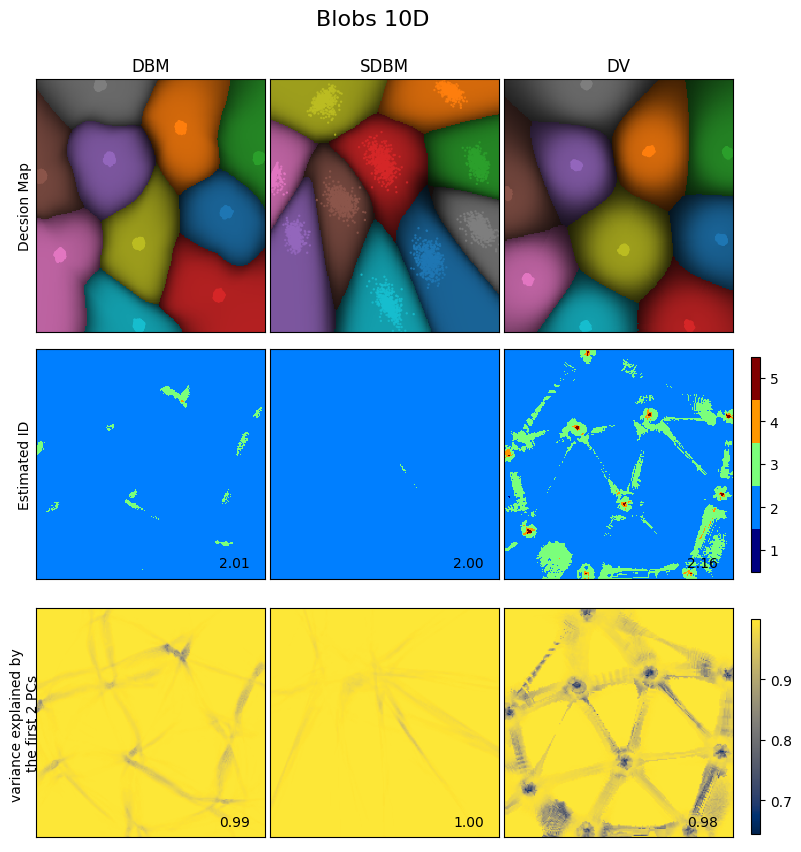

In [12]:
path = 'LID_results_new/blobs_dim10_n5000_y10_'
test = plot_LID2(path, threshold=0.95, title='Blobs 10D')
# plt.tight_layout()

# test.savefig('figures/blobs_dim10_n5000_y10_.png', dpi=300, bbox_inches='tight')

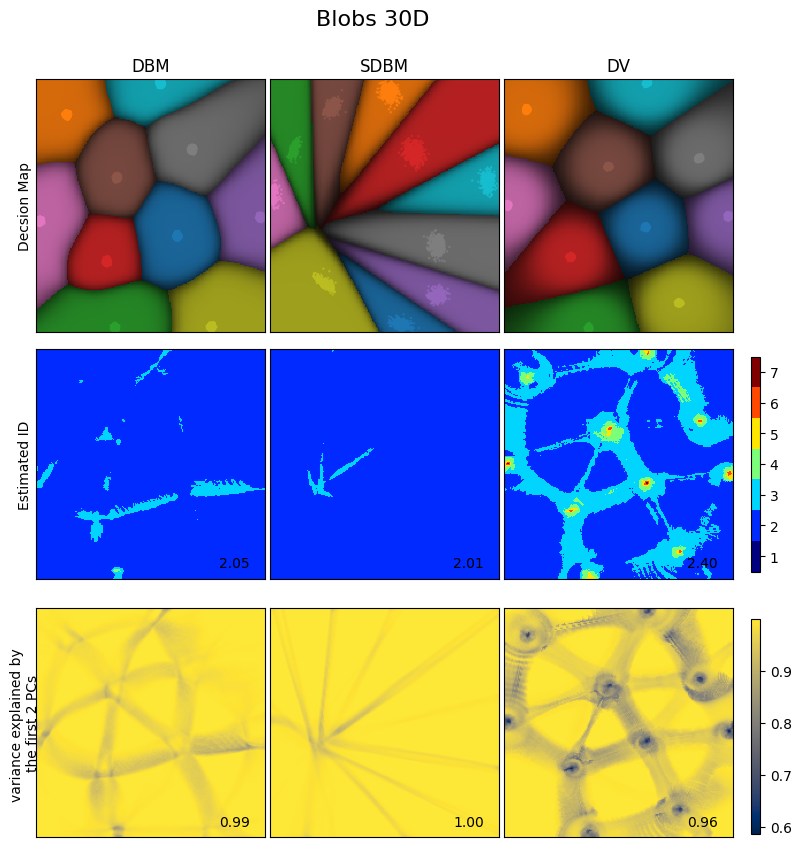

In [5]:
path = 'LID_results_new/blobs_dim30_n5000_y10_'
test = plot_LID2(path, threshold=0.95, title='Blobs 30D')
# plt.tight_layout()
# test.savefig('figures/blobs_dim30_n5000_y10_.png', dpi=300, bbox_inches='tight')

tensor([[7.6641e-01, 2.2880e-01, 1.1045e-03,  ..., 3.6763e-05, 3.6763e-05,
         3.6761e-05],
        [7.7204e-01, 2.2354e-01, 9.0222e-04,  ..., 3.5185e-05, 3.5184e-05,
         3.5073e-05],
        [7.5923e-01, 2.3652e-01, 8.4143e-04,  ..., 3.4066e-05, 3.4066e-05,
         3.4025e-05],
        ...,
        [7.7776e-01, 2.2174e-01, 4.3755e-05,  ..., 4.5291e-06, 4.5235e-06,
         4.5108e-06],
        [7.7294e-01, 2.2654e-01, 4.9744e-05,  ..., 4.6221e-06, 4.6179e-06,
         4.5846e-06],
        [7.7947e-01, 2.2001e-01, 5.0767e-05,  ..., 4.6495e-06, 4.6378e-06,
         4.5835e-06]])
tensor([[7.8770e-01, 2.1178e-01, 6.1267e-05,  ..., 4.1442e-06, 4.1441e-06,
         4.1437e-06],
        [7.7538e-01, 2.2407e-01, 7.5713e-05,  ..., 4.1905e-06, 4.1902e-06,
         4.1895e-06],
        [7.5321e-01, 2.4622e-01, 8.8047e-05,  ..., 4.2601e-06, 4.2474e-06,
         4.2387e-06],
        ...,
        [7.6559e-01, 2.3380e-01, 3.3321e-05,  ..., 5.3915e-06, 5.3914e-06,
         5.3898e-06],
   

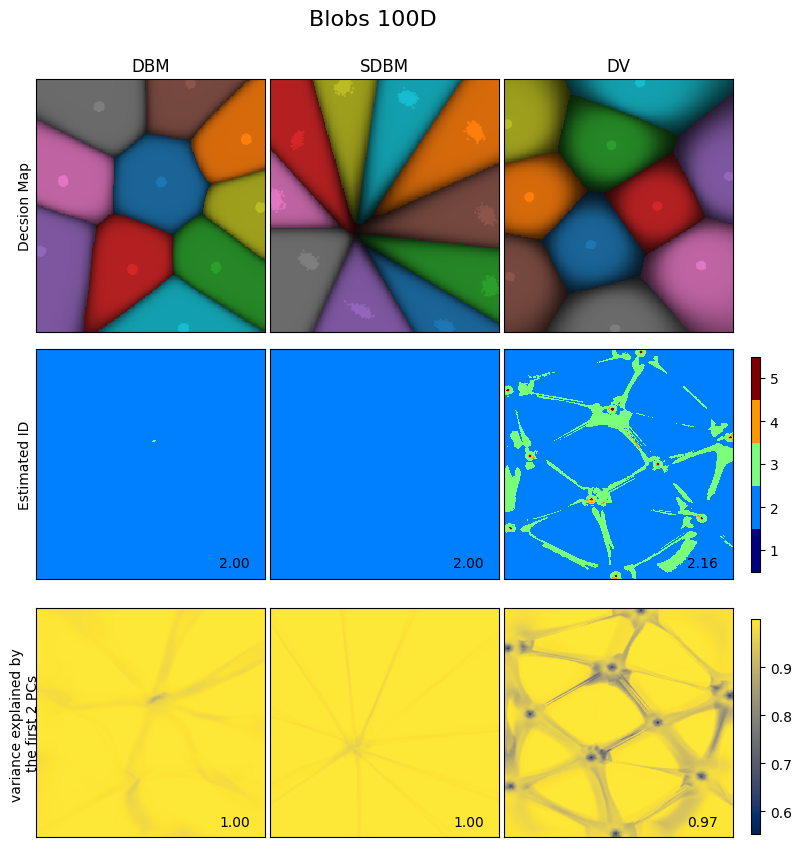

In [20]:
path = 'LID_results_new_grid500/blobs_dim100_n5000_y10_'
test = plot_LID2(path, threshold=0.95, title='Blobs 100D', mode1='minial_var')
# plt.tight_layout()
# test.savefig('figures/blobs_dim100_n5000_y10_.png', dpi=300, bbox_inches='tight')

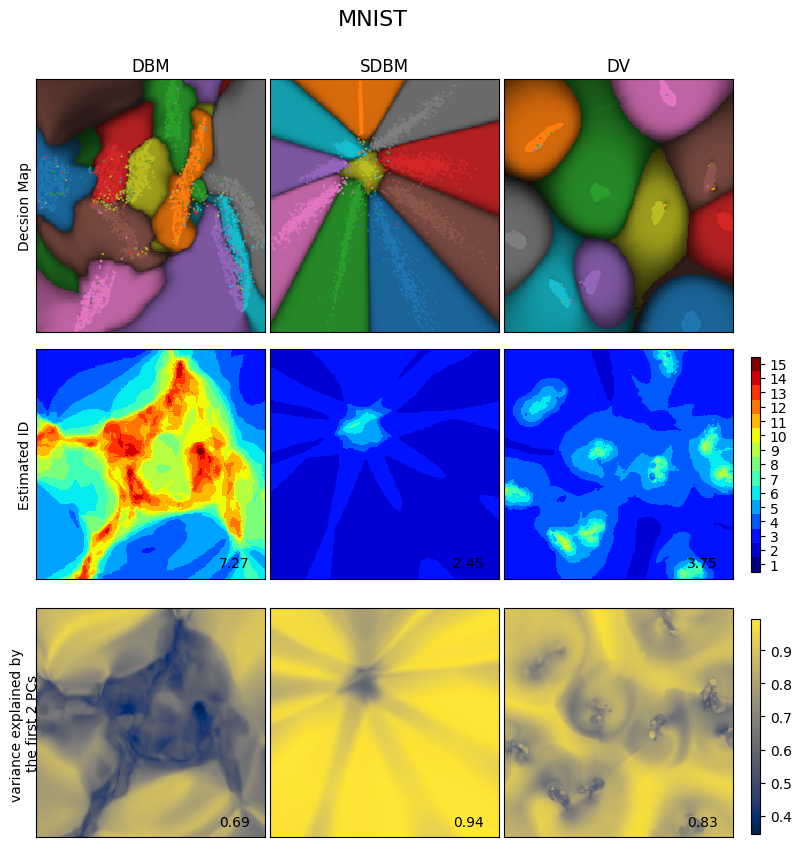

In [7]:
path = './LID_results_new_real/mnist_'
test = plot_LID2(path, threshold=0.95, title='MNIST')
# plt.tight_layout()
# test.savefig('figures/mnist_minimal_var.png', dpi=300, bbox_inches='tight')

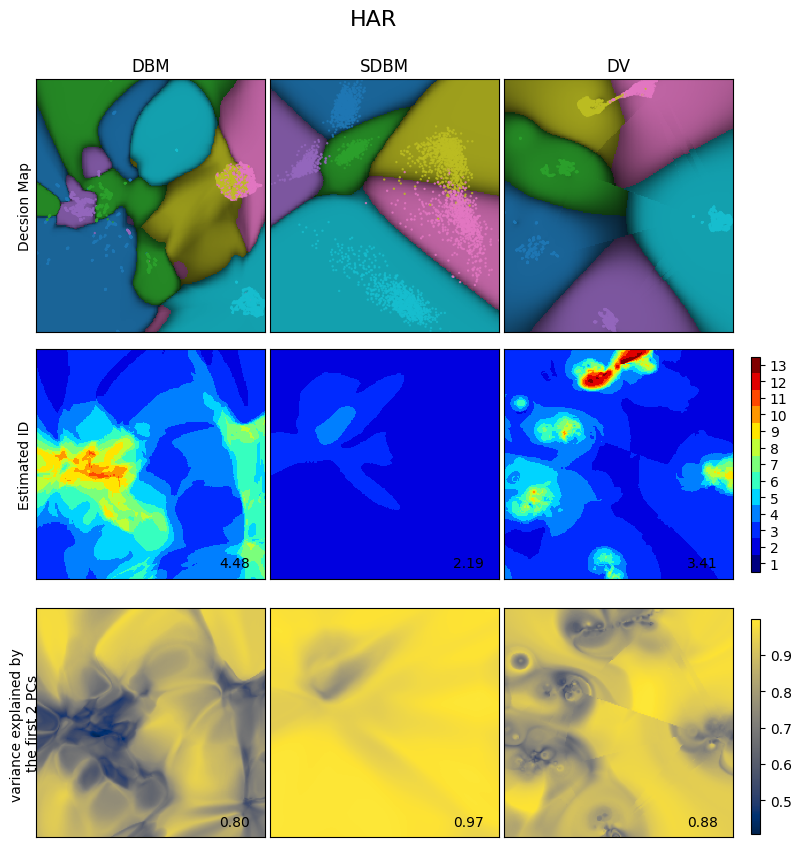

In [24]:
path = './LID_results_new_real/har_'
test = plot_LID2(path, threshold=0.95, title='HAR')
# plt.tight_layout()
# test.savefig('figures/har.png', dpi=300, bbox_inches='tight')

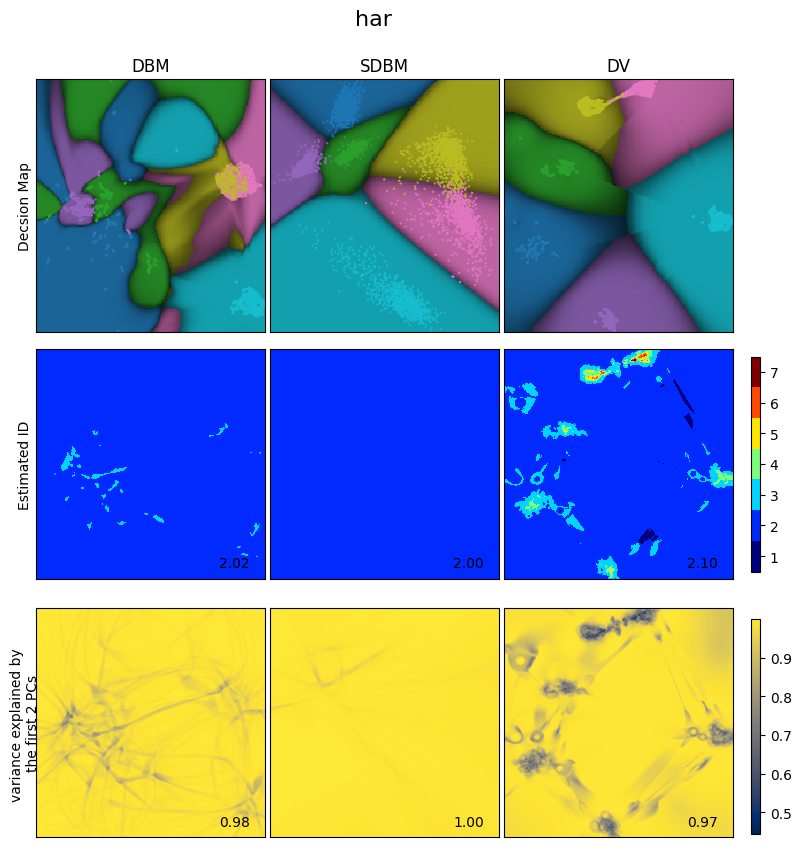

In [33]:
dim5 = plot_LID2('./LID_results_new_grid500/har_', threshold=0.90, title='har', mode1='dim')
# dim5.savefig('./figures/blobs_dim5_n1000_.png', dpi=300)


UnboundLocalError: local variable 'image' referenced before assignment

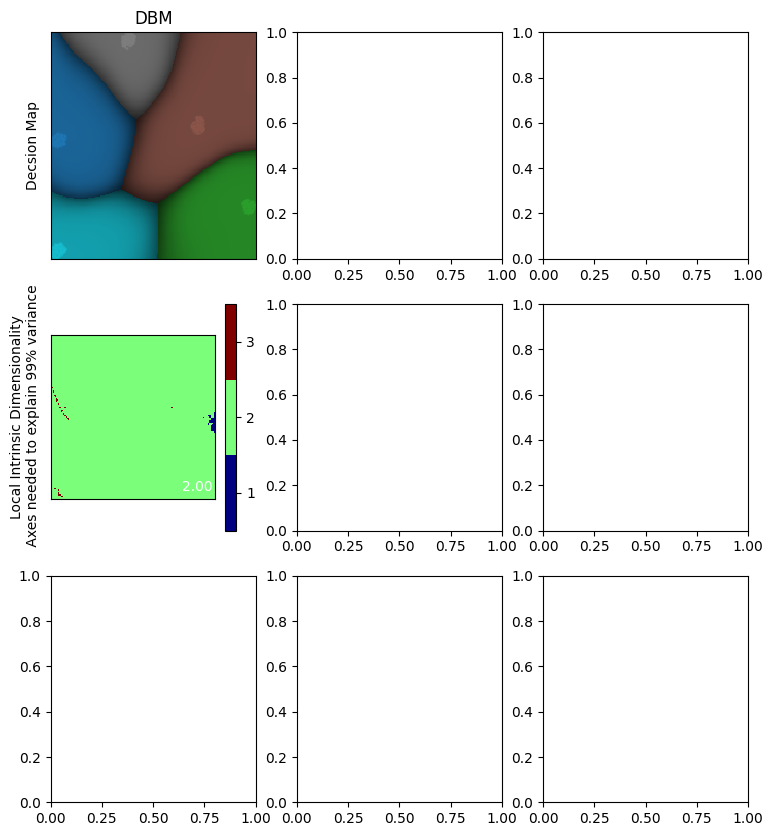

In [53]:
dim50 = plot_LID('./LID_results/blobs_dim50_n1000_', threshold=0.99, title='50D Blobs')
dim50.savefig('./figures/blobs_dim50_n1000_.png', dpi=300)

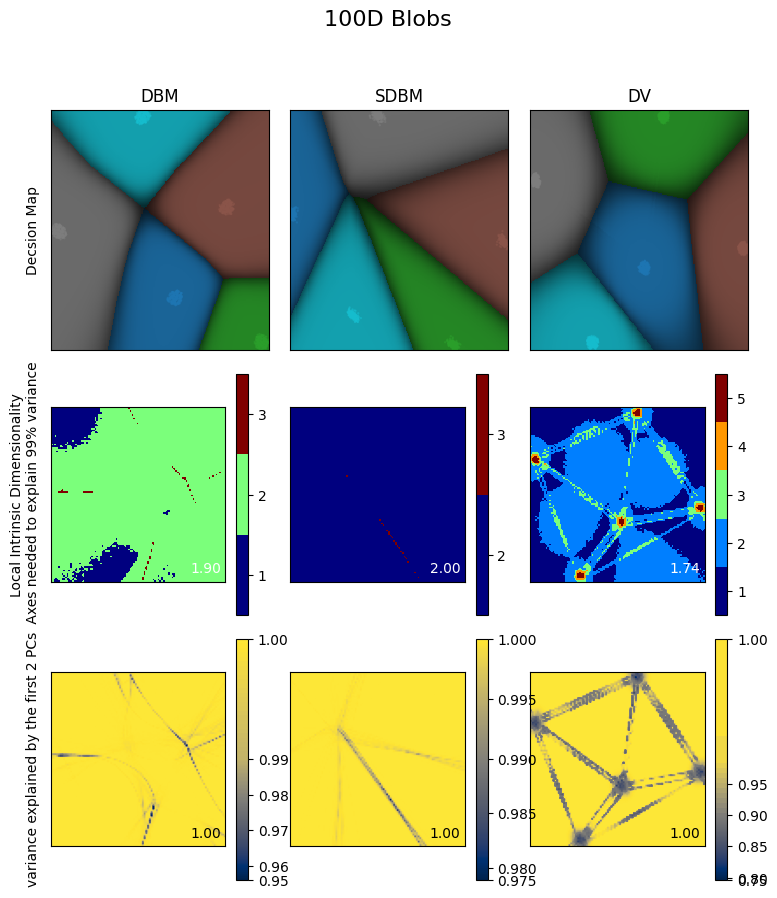

In [6]:
dim100 = plot_LID('./LID_results/blobs_dim100_n1000_', threshold=0.99, title='100D Blobs')
dim100.savefig('./figures/blobs_dim100_n1000_.png', dpi=300)

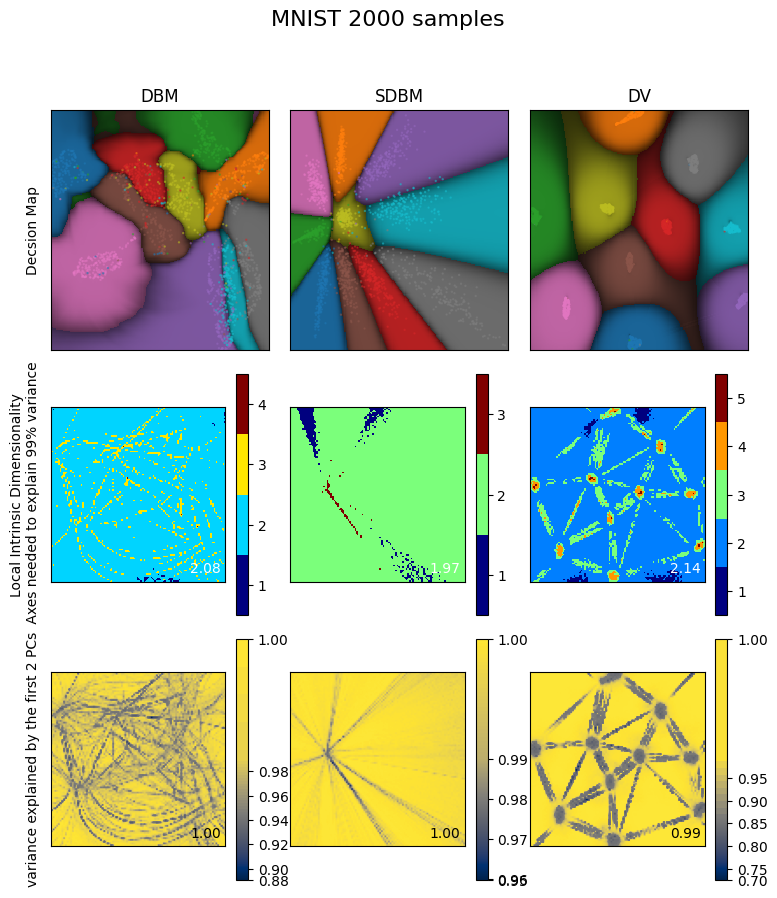

In [7]:
mnist = plot_LID('./LID_results/mnist_', threshold=0.99, title='MNIST 2000 samples')
mnist.savefig('./figures/mnist.png', dpi=300)

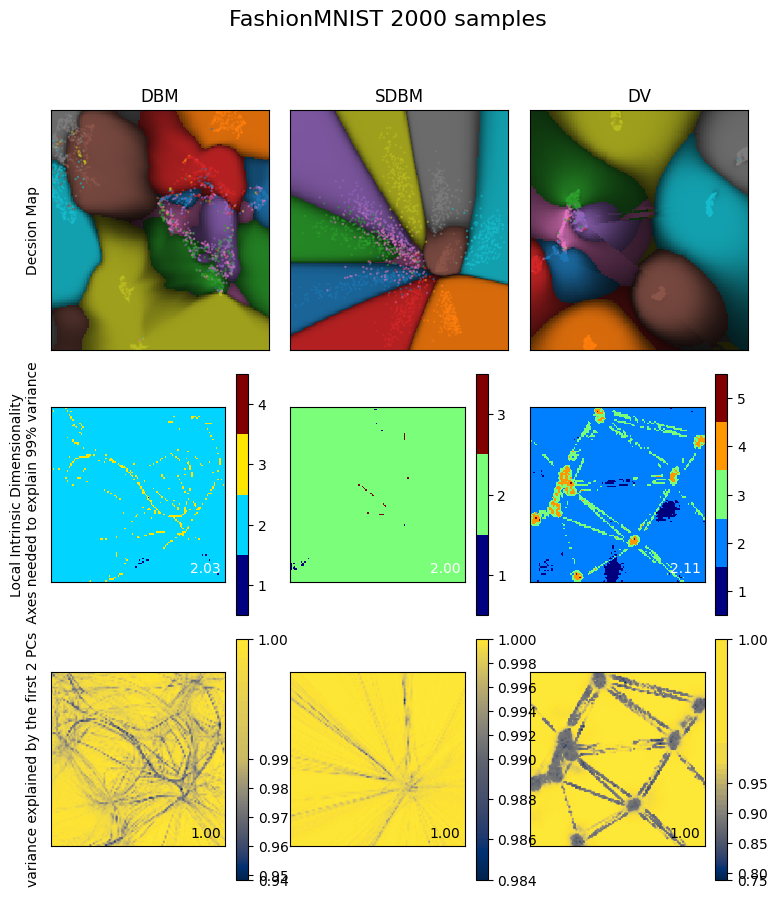

In [10]:
mnist = plot_LID('./LID_results/fashionmnist_', threshold=0.99, title='FashionMNIST 2000 samples')
mnist.savefig('./figures/fashionmnist.png', dpi=300)

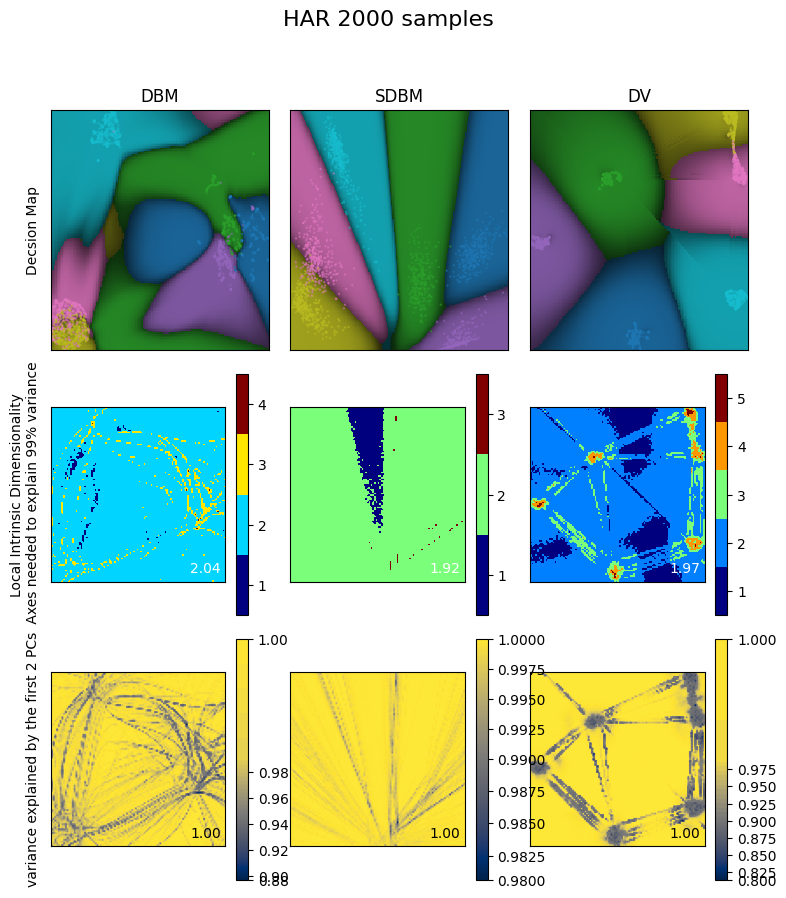

In [11]:
mnist = plot_LID('./LID_results/har_', threshold=0.99, title='HAR 2000 samples')
mnist.savefig('./figures/har.png', dpi=300)